In [25]:
# Cell 1: Imports and notebook settings
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted", context="notebook")
RANDOM_STATE = 42
CURRENT_YEAR = 2025
DATA_PATH = "House Price Prediction Dataset.csv"  # dataset path (provided)
print("Imports ready. Data path:", DATA_PATH)


Imports ready. Data path: House Price Prediction Dataset.csv


In [26]:
# Cell 2: Load dataset
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
display(df.head())
print("\nColumn dtypes and non-null counts:")
display(df.info())

Loaded dataset shape: (2000, 10)


,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056



Column dtypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null   int64 
 5   YearBuilt  2000 non-null   int64 
 6   Location   2000 non-null   object
 7   Condition  2000 non-null   object
 8   Garage     2000 non-null   object
 9   Price      2000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 156.4+ KB


None

Missing values (by column):


Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64


Descriptive statistics (numerical):


,count,mean,std,min,25%,50%,75%,max
Id,2000.0,1000.5000,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Area,2000.0,2786.2095,1295.146799,501.0,1653.00,2833.0,3887.50,4999.0
Bedrooms,2000.0,3.0035,1.424606,1.0,2.00,3.0,4.00,5.0
Bathrooms,2000.0,2.5525,1.108990,1.0,2.00,3.0,4.00,4.0
Floors,2000.0,1.9935,0.809188,1.0,1.00,2.0,3.00,3.0
YearBuilt,2000.0,1961.4460,35.926695,1900.0,1930.00,1961.0,1993.00,2023.0
Price,2000.0,537676.8550,276428.845719,50005.0,300098.00,539254.0,780086.00,999656.0


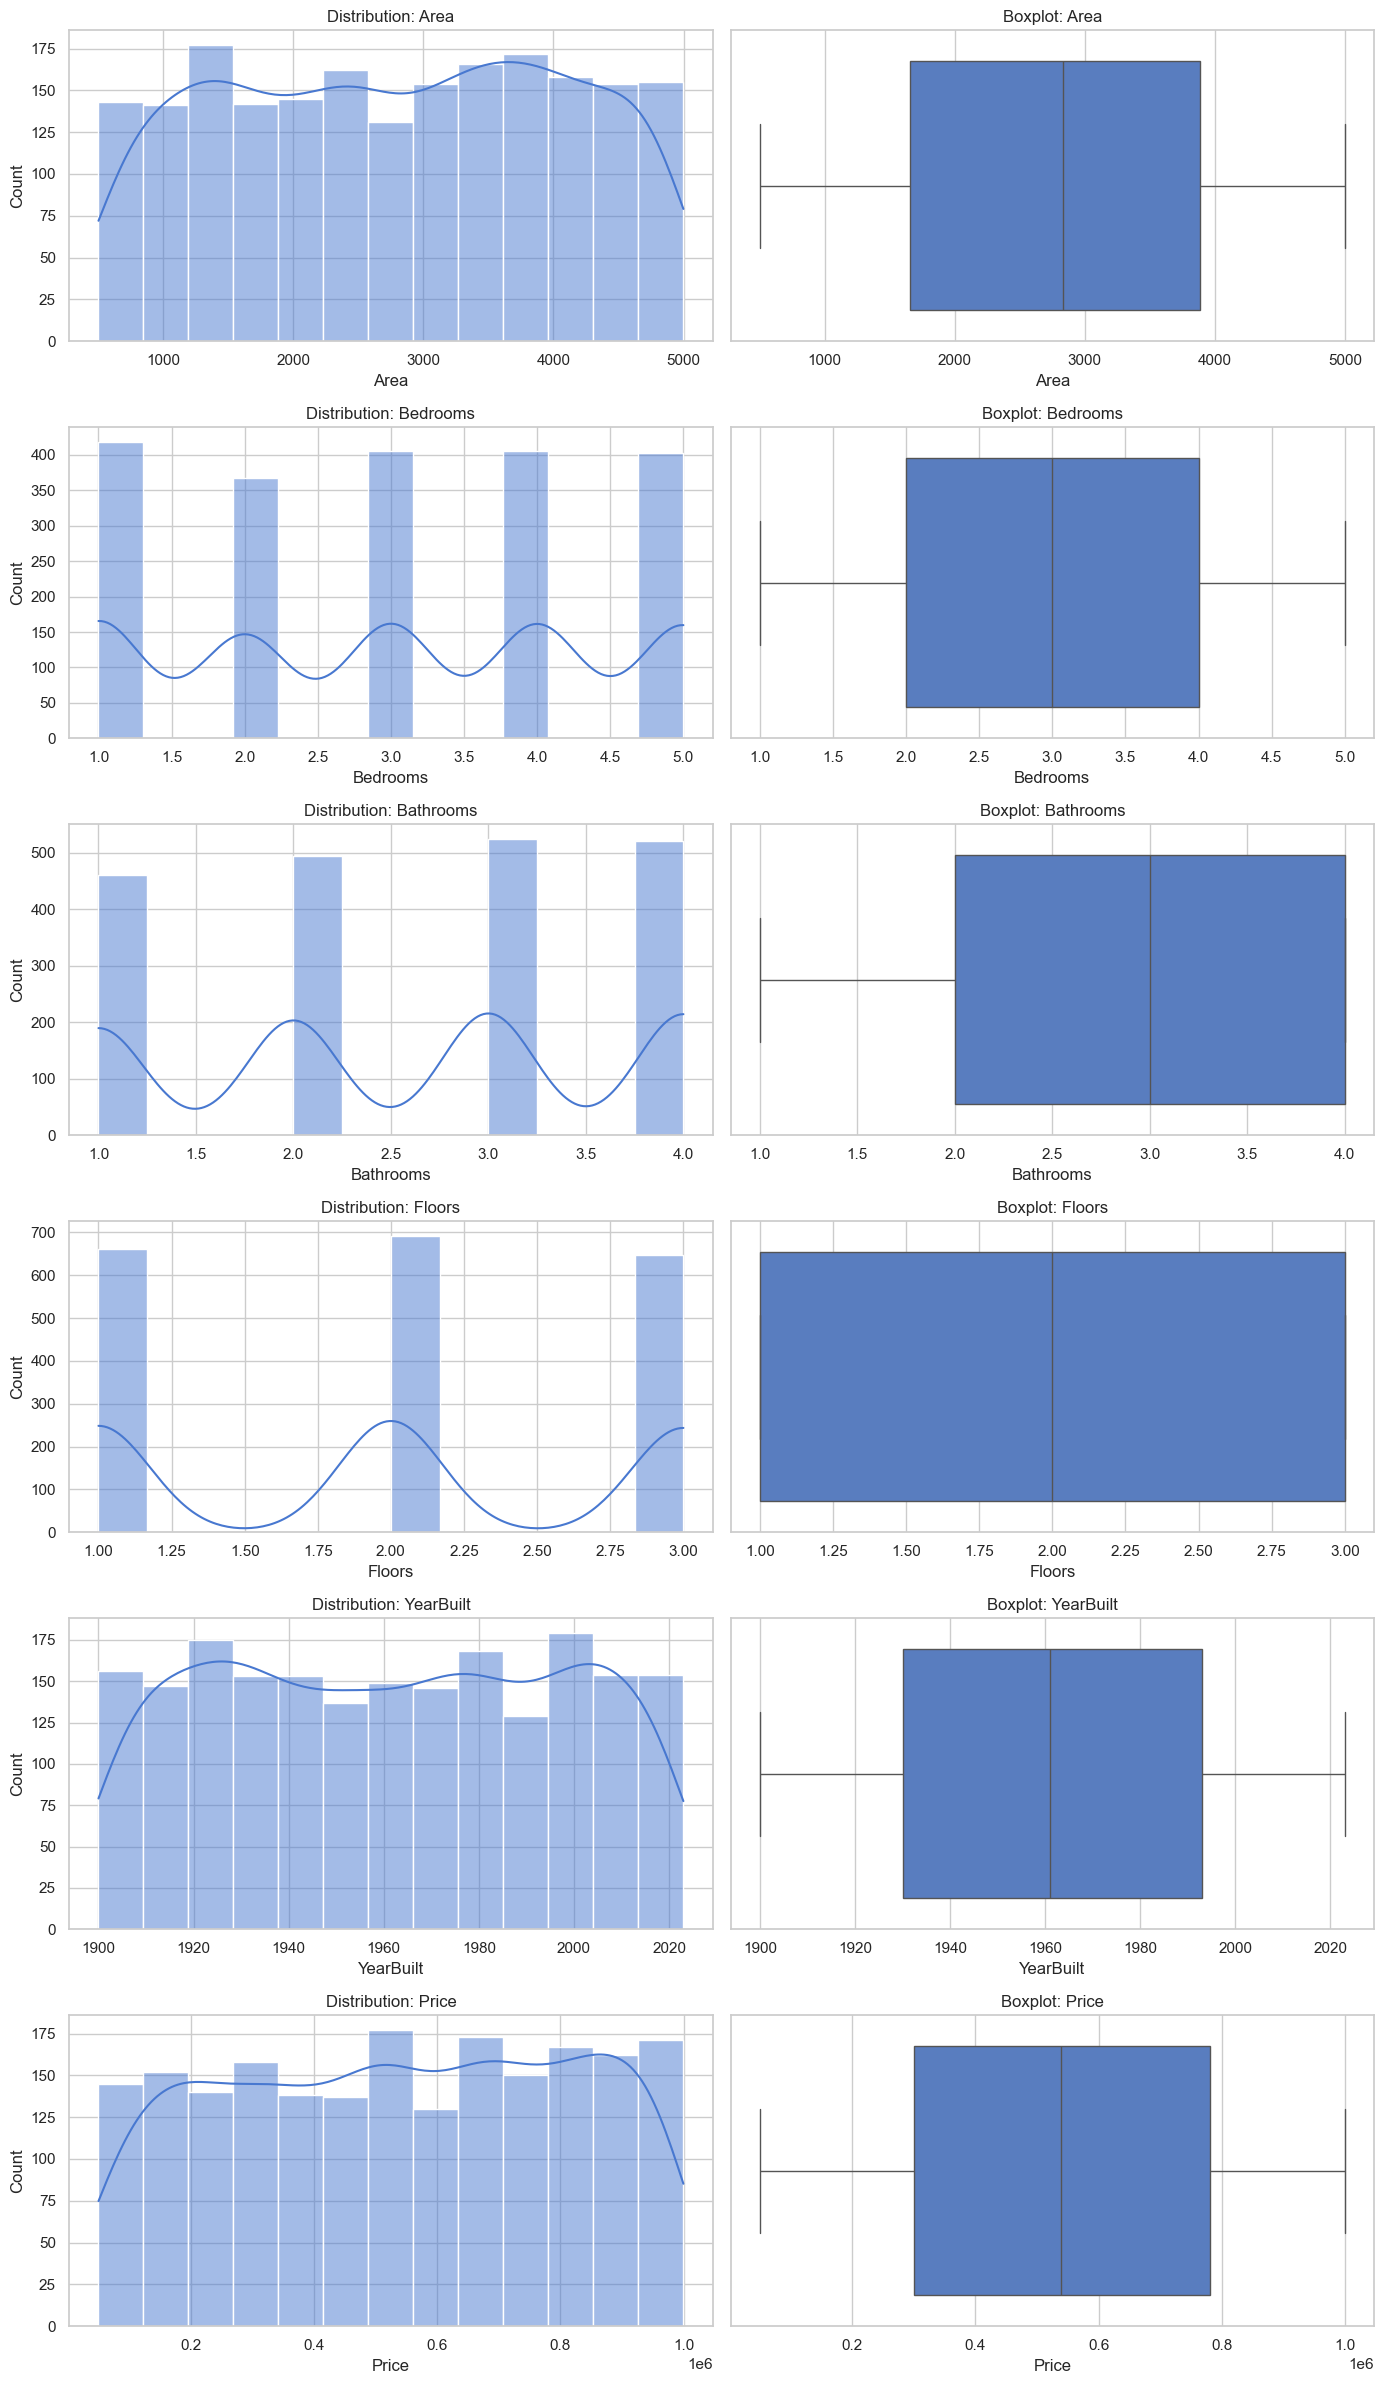

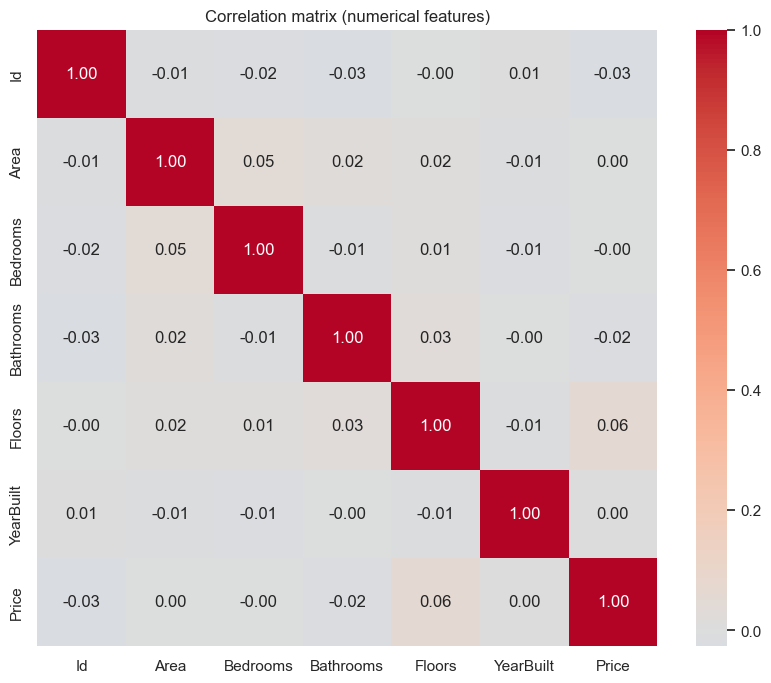

In [27]:
# Cell 3: EDA - missing values, basic stats, distributions, correlations
print("Missing values (by column):")
display(df.isna().sum())

print("\nDescriptive statistics (numerical):")
display(df.describe().T)

# Distribution plots for key numeric features (Area, Bedrooms, Price)
numeric_candidates = ["Area", "Bedrooms", "Bathrooms", "Floors", "YearBuilt", "Price"]
present_nums = [c for c in numeric_candidates if c in df.columns]

plt.figure(figsize=(14, 4 * len(present_nums)))
for i, col in enumerate(present_nums, 1):
    plt.subplot(len(present_nums), 2, 2*i - 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution: {col}")
    plt.subplot(len(present_nums), 2, 2*i)
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# Correlation heatmap (numerical)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(10, 8))
    corr = num_df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Correlation matrix (numerical features)")
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


In [28]:
# Cell 4: Preprocessing helper functions

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def cap_outliers(df_in, cols, lower_quantile=0.01, upper_quantile=0.99):
    """Cap numeric columns at specified quantiles to reduce outlier influence."""
    df = df_in.copy()
    for c in cols:
        if c in df.columns:
            low = df[c].quantile(lower_quantile)
            high = df[c].quantile(upper_quantile)
            df[c] = df[c].clip(lower=low, upper=high)
    return df

def compute_vif(df_numeric):
    """Compute VIF for a numeric DataFrame (no constant included)."""
    X = df_numeric.dropna().assign(intercept=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns.drop("intercept")
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(len(X.columns)-1)]
    return vif_data


In [29]:
# Cell 5: Preprocessing pipeline - drop Id, handle categories, create Age, impute, encode, scale

df_proc = df.copy()

# 1. Drop Id if present
if "Id" in df_proc.columns:
    df_proc = df_proc.drop(columns=["Id"])
    print("Dropped 'Id' column.")

# 2. Create Age from YearBuilt (and drop YearBuilt)
if "YearBuilt" in df_proc.columns:
    df_proc["Age"] = CURRENT_YEAR - df_proc["YearBuilt"]
    df_proc = df_proc.drop(columns=["YearBuilt"])
    print("Created 'Age' from 'YearBuilt' and dropped 'YearBuilt'.")

# 3. Basic cleaning: strip whitespace from categorical strings
for col in df_proc.select_dtypes(include=["object"]).columns:
    df_proc[col] = df_proc[col].astype(str).str.strip()

# 4. Identify features and target
TARGET = "Price"
if TARGET not in df_proc.columns:
    raise KeyError(f"Target column '{TARGET}' not found in data. Columns: {df_proc.columns.tolist()}")

# Separate feature types
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET]
cat_cols = df_proc.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric columns: {numeric_cols}")
print(f"Categorical columns: {cat_cols}")

# 5. Handle missing values and outliers for numeric columns
# Impute missing numeric values using median
num_imputer = SimpleImputer(strategy="median")
df_proc[numeric_cols] = pd.DataFrame(num_imputer.fit_transform(df_proc[numeric_cols]), columns=numeric_cols)

# Cap outliers
df_proc = cap_outliers(df_proc, numeric_cols)

# 6. Handle categorical missing by filling mode
for c in cat_cols:
    df_proc[c] = df_proc[c].fillna(df_proc[c].mode()[0])

# 7. (Optional) Check multicollinearity and drop features with very high VIF (>10)
try:
    vif_df = compute_vif(df_proc[numeric_cols])
    print("\nVIF before dropping high-VIF features:")
    display(vif_df)
    high_vif = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
    if high_vif:
        print("Dropping features due to high VIF:", high_vif)
        # drop them from numeric columns list (do not drop automatically from df yet to preserve integrity)
        numeric_cols = [c for c in numeric_cols if c not in high_vif]
except Exception as e:
    print("VIF computation skipped (statsmodels may not be installed). Error:", e)

# Final feature matrix X and target y
X = df_proc[numeric_cols + cat_cols].copy()
y = df_proc[TARGET].copy()

print("\nFinal feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Dropped 'Id' column.
Created 'Age' from 'YearBuilt' and dropped 'YearBuilt'.
Numeric columns: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'Age']
Categorical columns: ['Location', 'Condition', 'Garage']

VIF before dropping high-VIF features:


,feature,VIF
0,Area,1.003170
1,Bedrooms,1.002723
2,Bathrooms,1.001480
3,Floors,1.001275
4,Age,1.000357



Final feature matrix shape: (2000, 8)
Target shape: (2000,)


In [30]:
# Cell 6: Build ColumnTransformer with numeric scaling and one-hot encoding for categories
# Use drop='first' to avoid dummy variable trap (reduces collinearity)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 8) Test shape: (400, 8)


In [31]:
# Cell 7: Train models
# 1) Linear Regression pipeline
pipe_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 2) Gradient boosting: try XGBoost first, fallback to sklearn's GradientBoostingRegressor
try:
    import xgboost as xgb
    gb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE, verbosity=0)
    gb_name = "XGBoost"
except Exception as e:
    print("XGBoost not available, falling back to sklearn's GradientBoostingRegressor. Error:", e)
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE)
    gb_name = "GradientBoosting"

pipe_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", gb_model)
])

# Fit models
print("Training Linear Regression...")
pipe_lr.fit(X_train, y_train)
print("Training", gb_name, "...")
pipe_gb.fit(X_train, y_train)

print("Training completed.")


XGBoost not available, falling back to sklearn's GradientBoostingRegressor. Error: No module named 'xgboost'
Training Linear Regression...
Training GradientBoosting ...
Training completed.



--- Linear Regression ---
MAE: 243241.4882
RMSE: 279858.7614
R²: -0.0067

--- GradientBoosting ---
MAE: 247092.5745
RMSE: 286749.6527
R²: -0.0569

Best Model Selected: Linear Regression


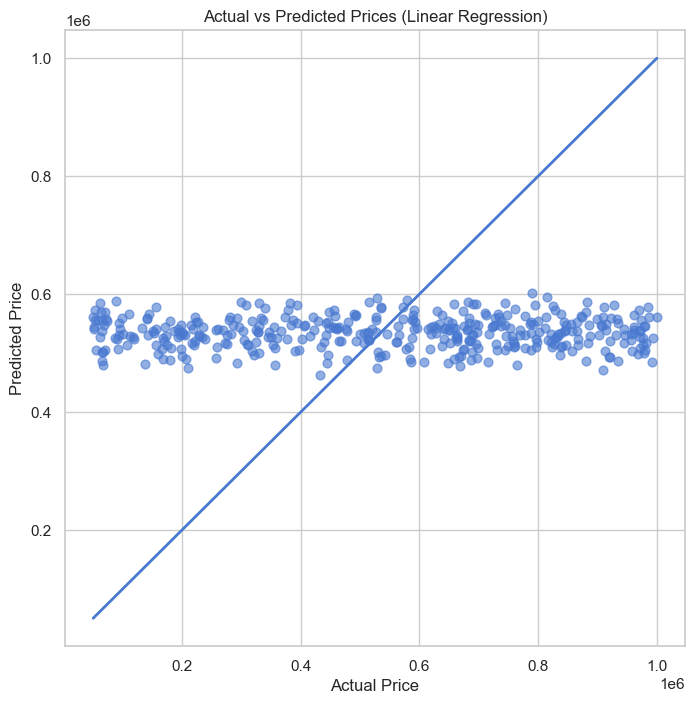

In [38]:
# ==========================================================
# Combined Evaluation + Best Model Selection + Scatter Plot
# ==========================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(pipe, X_test, y_test, name):
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    
    # Compute RMSE manually (compatible with all sklearn versions)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    
    r2 = r2_score(y_test, preds)

    print(f"\n--- {name} ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    return preds, mae, rmse, r2


# Evaluate models
preds_lr, mae_lr, rmse_lr, r2_lr = evaluate_model(pipe_lr, X_test, y_test, "Linear Regression")
preds_gb, mae_gb, rmse_gb, r2_gb = evaluate_model(pipe_gb, X_test, y_test, gb_name)


# ==========================================================
# Select Best Model (based on lowest RMSE)
# ==========================================================

if rmse_lr < rmse_gb:
    best_model_pipe = pipe_lr
    best_model_name = "Linear Regression"
    preds_best = preds_lr
else:
    best_model_pipe = pipe_gb
    best_model_name = gb_name
    preds_best = preds_gb

print(f"\nBest Model Selected: {best_model_name}")


# ==========================================================
# Scatter Plot (Actual vs Predicted)
# ==========================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, preds_best, alpha=0.6, s=40)

# Perfect prediction reference line
min_val = min(y_test.min(), preds_best.min())
max_val = max(y_test.max(), preds_best.max())
plt.plot([min_val, max_val], [min_val, max_val], linewidth=2)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted Prices ({best_model_name})")
plt.show()


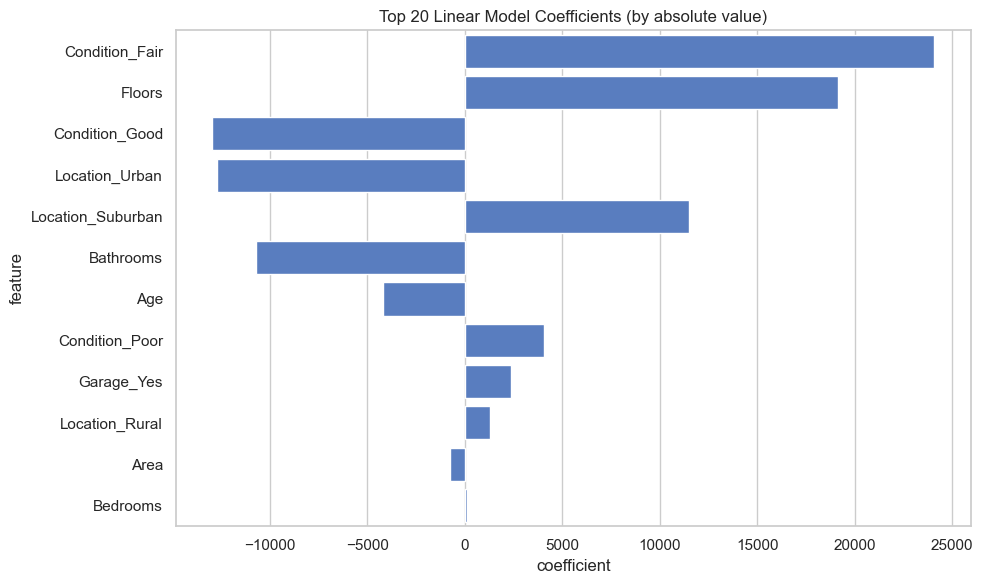

In [39]:
# Cell 10: Feature importances or linear coefficients
if best_model_name == gb_name:
    # Extract feature names after preprocessing
    # We need to get the one-hot column names from the preprocessor
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_feature_names = ohe.get_feature_names_out(cat_cols)
    except:
        # compatibility fallback
        cat_feature_names = ohe.get_feature_names(cat_cols)
    feature_names = numeric_cols + list(cat_feature_names)
    # Get feature importances from underlying regressor
    importances = best_model_pipe.named_steps['regressor'].feature_importances_
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    plt.figure(figsize=(10,6))
    sns.barplot(data=fi_df.head(20), x="importance", y="feature")
    plt.title(f"Top 20 Feature Importances ({best_model_name})")
    plt.tight_layout()
    plt.show()
else:
    # Linear regression coefficients
    # Need to extract coefficients in original feature names space after one-hot encoding
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_feature_names = ohe.get_feature_names_out(cat_cols)
    except:
        cat_feature_names = ohe.get_feature_names(cat_cols)
    feature_names = numeric_cols + list(cat_feature_names)
    coefs = best_model_pipe.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
    coef_df["abs_coef"] = coef_df["coefficient"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(data=coef_df.head(20), x="coefficient", y="feature")
    plt.title("Top 20 Linear Model Coefficients (by absolute value)")
    plt.tight_layout()
    plt.show()


In [41]:
# Cell 11: Save the best model pipeline + download link (works perfectly in Jupyter/Colab/Kaggle)

import joblib
import os
from IPython.display import FileLink

# Define the filename
MODEL_FILENAME = "best_house_price_model.pkl"
MODEL_PATH = f"/content/{MODEL_FILENAME}"  # Works in Colab
if not os.path.exists("/content"):
    MODEL_PATH = MODEL_FILENAME  # Fallback for local Jupyter or Kaggle

# Save the best model pipeline (make sure 'best_model_pipe' exists from previous cells)
joblib.dump(best_model_pipe, MODEL_PATH)
print(f"Best model saved successfully as '{MODEL_FILENAME}'")
print(f"File size: {os.path.getsize(MODEL_PATH) / 1024:.1f} KB")

# Create a downloadable link (especially useful in Google Colab)
if os.path.exists(MODEL_PATH):
    display(FileLink(MODEL_PATH))
else:
    print("Model file not found. Check the path.")

Best model saved successfully as 'best_house_price_model.pkl'
File size: 5.5 KB


C:\Users\conta\AI Internship\Untitled Folder\best_house_price_model.pkl